# War card game analysis
Assumptions:
- if there are n players, then every player gets *(52 mod n)* cards and there are *(52 mod n) * n* cards in game
- non-playing cards are chosen from the lowest ones
- if there is a war and a player is out of cards (therefore can't continue the war), that player loses
- if a player has no cards in a hand but has in the side stack, then cards from the side stack will be shuffled and added to player's hand
- if a war occurs it is still counted as 1 move (no matter how long the war lasts).

e.g. if there are n = 3 players:
- num_of_cards_per_player = 52 mod 3 = 17
- num_of_cards_in_game = 17 * 3 = 51
- deck = [2, 3, 3, 3, 3, 4, ...]

## Simulations

In [103]:
# libraries
import pandas as pd
import ipywidgets as widgets
from tqdm import tqdm

In [93]:
# Defining deck of cards and card values
"""
Jack = 11
Queen = 12
King = 13
Ace = 14
"""
card_values = list(range(2, 15))
deck = list(4 * card_values)
deck.sort()

print(deck)

[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14]


In [95]:
def check_hands(players):
    to_remove = []
    
    for i, player in enumerate(players):
        
        # if hand is empty
        if len(player['hand']) < 1:
            
            if len(player['side']) > 0:
                # shuffle side cards and move them to the hand
                np.random.shuffle(player['side'])
                player['hand'], player['side'] = player['side'], []
            else:
                # save index of player who lost (has no cards at all)
                to_remove.append(i)

    # remove players who lost
    for i in reversed(to_remove):
        players.pop(i)

In [97]:
def make_move(players, cards_for_side, print_cards=True, ignore_values=False):
    """
    players: list of players with hands and sides (or list of players who take part in a war)
    cards_for_side: list of cards accumulated in the round that will be added to winner's side cards
    ignore_values: used in war for cards that are reversed and their values are not taken into account
    return: True if game over, else False
    """
    
    check_hands(players)
    if len(players) <= 1:
        return True

    # throw cards
    players_cards = []
    for player in players:
        players_cards.append(player['hand'].pop(0))

    # uncomment to print output
    """
    if print_cards:
        with output_widget:
            for card in players_cards:
                print(card, end="\t")
            print()
    """
    cards_for_side += players_cards

    # war: thrown cards are reversed, now throw cards whose values count
    if ignore_values:

        # uncomment to print output
        """
        with output_widget:
            print("(above cards are reversed)")
        """
        make_move(players, cards_for_side, print_cards, False)
        
    # war: thrown cards' values count, now throw reversed cards
    # no war: choose the winner and add accumulated cards to his side
    else:
        max_card_value = max(players_cards)
            
        # war
        if players_cards.count(max_card_value) > 1:
            # find and save indexes of players who have a war
            players_with_highest_cards = [i for i, value in enumerate(players_cards) if value == max_card_value]
            players_on_war = [players[i] for i in players_with_highest_cards]

            # uncomment to print output
            """
            if print_cards:
                with output_widget:
                    print("players on war: ", end="")
                    print([x+1 for x in players_with_highest_cards])
                    print("WAAAAR!!!!")
            """
            
            # war between specific players
            make_move(players_on_war, cards_for_side, print_cards, True)
            
        # no war
        else:
            winner_index = players_cards.index(max_card_value)
            players[winner_index]['side'] += cards_for_side
    
    return False

In [99]:
def deal_cards(players_number, seed=1):
    num_of_cards_in_game = 52 // players_number * players_number
    num_of_cards_per_player = num_of_cards_in_game // players_number

    players = [ {'hand': [], 'side': []} for _ in range(players_number) ]
        
    # shuffle cards 
    shuffled_deck = deck.copy()
    shuffled_deck = deck[52-num_of_cards_in_game:]
    np.random.seed(seed)
    np.random.shuffle(shuffled_deck)

    # deal cards to players
    for j, player in enumerate(players):
        player['hand'] = shuffled_deck[:num_of_cards_per_player]
        shuffled_deck = shuffled_deck[num_of_cards_per_player:]
        # uncomment to print output
        """
        with output_widget:
            print(f"start state: player{j+1}\nhand: {player['hand']}\nside: {player['side']}")
        with output_widget:
            print()
        """
        
    return players

In [101]:
def war_card_game_simulation(N, players_number, start_seed=1):
    # variables
    rounds_in_each_simulation = []
    
    # simulations
    for i in tqdm(range(N)):
        # uncomment to print output
        """
        if i == 0: # print only first simulation
            with output_widget:
                print(f"-------------------- {i+1}. SIMULATION ------------------------------")
        """
        
        players = deal_cards(players_number, seed=start_seed+i)
        game_over = False
        iter = 0
        print_cards = i == 0
        
        # game until someone wins
        while not game_over:
            game_over = make_move(players, [], print_cards)
            iter += 1
            # uncomment to print output
            """
            if i == 0:
                with output_widget:
                    print(f"after {iter}. round:")
                    for j, player in enumerate(players):    
                        print(f"player{j+1}\nhand: {player['hand']}\nside:{player['side']}") 
                    print()
            """
        rounds_in_each_simulation.append(iter-1)
        
    return rounds_in_each_simulation

### Example simulation output
To print simulation output you need to delete comments in above functions.

In [60]:
output_widget = widgets.Output(layout=widgets.Layout(width='100%', height='500px', overflow_y='auto'))
exapmle_to_print = war_card_game_simulation(N = 1, players_number = 3, start_seed=2)
display(output_widget)

### Run simulations

In [36]:
rounds_in_100_000_simulations_2_players = war_card_game_simulation(N = 100000, players_number = 2, start_seed=123)

# check result
print(rounds_in_100_000_simulations_2_players[:10])
print(len(rounds_in_100_000_simulations_2_players))

100%|██████████| 100000/100000 [00:51<00:00, 1943.90it/s]

[325, 192, 1054, 178, 298, 707, 132, 1117, 101, 140]
100000


In [34]:
rounds_in_100_000_simulations_3_players = war_card_game_simulation(N = 100000, players_number = 3, start_seed=123)

100%|██████████| 100000/100000 [00:51<00:00, 1935.52it/s]


In [37]:
rounds_in_100_000_simulations_4_players = war_card_game_simulation(N = 100000, players_number = 4, start_seed=123)

100%|██████████| 100000/100000 [00:53<00:00, 1868.00it/s]


In [38]:
rounds_in_100_000_simulations_5_players = war_card_game_simulation(N = 100000, players_number = 5, start_seed=123)

100%|██████████| 100000/100000 [00:47<00:00, 2088.68it/s]


### Save results to files

In [72]:
df = pd.DataFrame(rounds_in_100_000_simulations_2_players, columns=['rounds'])
df.to_csv('simulation_results/rounds_in_100_000_simulations_2_players.csv', index=False)

df = pd.DataFrame(rounds_in_100_000_simulations_3_players, columns=['rounds'])
df.to_csv('simulation_results/rounds_in_100_000_simulations_3_players.csv', index=False)

df = pd.DataFrame(rounds_in_100_000_simulations_4_players, columns=['rounds'])
df.to_csv('simulation_results/rounds_in_100_000_simulations_4_players.csv', index=False)

df = pd.DataFrame(rounds_in_100_000_simulations_5_players, columns=['rounds'])
df.to_csv('simulation_results/rounds_in_100_000_simulations_5_players.csv', index=False)

# Analysis

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Analysis - 2 players and 100 000 simulations

### Load simulation results

In [80]:
rounds_2_players = pd.read_csv('simulation_results/rounds_in_100_000_simulations_2_players.csv')
rounds_2_players.head()

,rounds
0,325
1,192
2,1054
3,178
4,298


### Show basic statistal parameters

In [84]:
rounds_2_players.describe()

,rounds
count,100000.000000
mean,434.820260
std,353.498203
min,20.000000
25%,186.000000
50%,330.000000
75%,574.000000
max,4237.000000


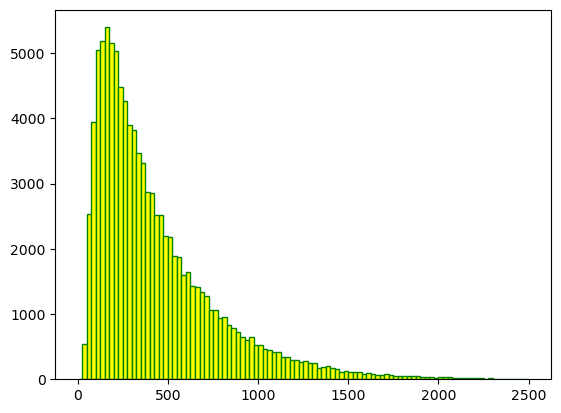

In [86]:
plt.hist(rounds_2_players, bins=100, range=(0, 2500), density=False, ec="green", color="yellow")
plt.show()